# Transfer Learning with Pre-trained Models on Oxford Flowers 102

## Introduction
This notebook explores the application of transfer learning using popular pre-trained convolutional neural network architectures to address the image classification task on the Oxford Flowers 102:2.1.1 dataset. Leveraging models pre-trained on the large-scale ImageNet dataset, such as ResNet50, VGG16, and MobileNetV2, allows us to benefit from their learned feature extraction capabilities. The goal is to adapt these powerful models to the finer-grained classification challenges presented by Oxford Flowers 102, which consists of 102 distinct classes. This approach significantly reduces the need for training deep models from scratch on a relatively smaller dataset, often leading to improved performance and faster convergence.

## Project Flow

1.  **Data Loading and Preprocessing**: Load the Oxford Flowers 102 dataset and apply the necessary preprocessing steps tailored for each pre-trained model (ResNet50, VGG16, MobileNetV2). This involves scaling pixel values and resizing images to match the input requirements of the chosen architectures ***(224, 224, 3)***.

2.  **Model Preparation**:
    *   Load pre-trained models (ResNet50, VGG16, MobileNetV2) without their top classification layers.
    *   Add new custom classification layers suitable for the 102 classes of Oxford Flowers 102.
    *   Freeze the layers of the pre-trained base models to retain the learned features during initial training.
    *   Compile the models with an appropriate optimizer, loss function, and metrics.

3.  **Fine-Tuning and Training**:
    *   Train the modified models on the preprocessed training data, monitoring performance on the validation set.

4.  **Model Evaluation**: Evaluate the performance of each trained model (ResNet50, VGG16, MobileNetV2) on the held-out test dataset using relevant metrics such as *accuracy* and *macro f1 score*.

5. **Comparison of Results**: Compare the performance of the different models to understand the effectiveness of each architecture.

## 1. Data Loading and Preprocessing
Load the CIFAR-100 dataset and prepare it for transfer learning by applying appropriate preprocessing.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    train_ds = dataset['train']
    val_ds = dataset['validation']
    test_ds = dataset['test']

    print(info)
except Exception as e:
    print(f"Error loading dataset: {e}")

2025-09-16 21:54:05.969137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758059645.988699  202980 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758059645.994681  202980 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-16 21:54:06.016079: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.12/site-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.4

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

I0000 00:00:1758059651.219252  202980 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10527 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0f:00.0, compute capability: 6.1


2025-09-16 21:54:11.682491: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-09-16 21:54:12.046908: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


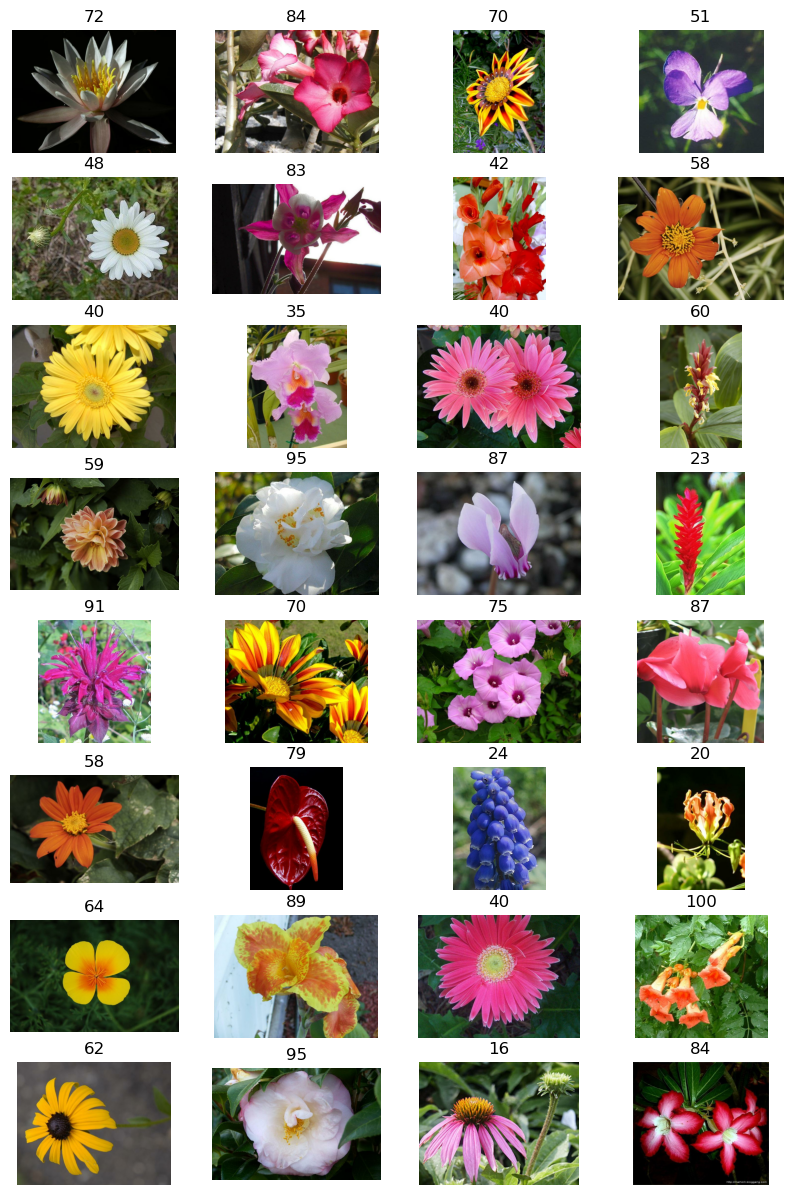

In [2]:
plt.figure(figsize=(10, 15))
i = 0
for img, label in train_ds.take(32):
    i += 1
    plt.subplot(8, 4, i)
    plt.title(label.numpy())
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [3]:
for img, _ in train_ds.take(1):
    print("Image Shape: ", img.shape)
    print("Image Pixel Value range [", np.min(img.numpy()), ",", np.max(img.numpy()), "] ", img.dtype)

Image Shape:  (500, 667, 3)
Image Pixel Value range [ 0 , 255 ]  <dtype: 'uint8'>


2025-09-16 21:54:13.568661: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal_and_vertical'),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2))
])

def resize_img(img, label):
    img, label = tf.image.resize(img, (224, 224)), keras.utils.to_categorical(x=label, num_classes=102)
    img = data_augmentation(img)
    return img, label

def resize_only(img, label):
    img, label = tf.image.resize(img, (224, 224)), keras.utils.to_categorical(x=label, num_classes=102)
    return img, label

train_ds = train_ds.map(resize_img).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(resize_only).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(resize_only).batch(32).prefetch(tf.data.AUTOTUNE)

In [5]:
for img, label in train_ds.take(1):
    print("Image Shape: ", img.shape)
    print("Image Pixel Value range [", np.min(img.numpy()), ",", np.max(img.numpy()), "] ", img.dtype)
    print("Label: ", label)

Image Shape:  (32, 224, 224, 3)
Image Pixel Value range [ 0.0 , 255.0 ]  <dtype: 'float32'>
Label:  tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(32, 102), dtype=float32)


In [6]:
resnet_processor = keras.applications.resnet.preprocess_input
vgg16_processor = keras.applications.vgg16.preprocess_input
mobilenet_processor = keras.applications.mobilenet_v2.preprocess_input

In [7]:
train_ds_resnet = train_ds.map(lambda img, label: (resnet_processor(img), label))
train_ds_vgg = train_ds.map(lambda img, label: (vgg16_processor(img), label))
train_ds_mobilenet = train_ds.map(lambda img, label: (mobilenet_processor(img), label))

In [8]:
val_ds_resnet = val_ds.map(lambda img, label: (resnet_processor(img), label))
val_ds_vgg = val_ds.map(lambda img, label: (vgg16_processor(img), label))
val_ds_mobilenet = val_ds.map(lambda img, label: (mobilenet_processor(img), label))

## 2. Model Preparation
Load and modify pre-trained models to fit the Oxford Flowers 102 classification task.

### Writing helper methods for
### 2.1 ResNet50
### 2.2 VGG16
### 2.3 MobileNetV2

In [9]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-7)


def build_resnet_model():
    i = keras.layers.Input(shape=(224, 224, 3), dtype="float32")
    core = keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
    )
    core.trainable = False
    x = core(i)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dropout(0.5)(x)
    o = keras.layers.Dense(102, activation="softmax")(x)

    model = keras.Model(inputs=[i], outputs=[o])
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            keras.metrics.F1Score(name="f1_score", average="macro"),
            keras.metrics.CategoricalAccuracy(name="accuracy"),
        ],
    )
    model.summary()
    return model


def build_vgg16_model():
    i = keras.layers.Input(shape=(224, 224, 3), dtype="float32")
    core = keras.applications.VGG16(
        include_top=False,
        weights="imagenet",
    )
    core.trainable = False
    x = core(i)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dropout(0.5)(x)
    o = keras.layers.Dense(102, activation="softmax")(x)

    model = keras.Model(inputs=[i], outputs=[o])
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            keras.metrics.F1Score(name="f1_score", average="macro"),
            keras.metrics.CategoricalAccuracy(name="accuracy"),
        ],
    )
    model.summary()
    return model


def build_mobilenet_model():
    i = keras.layers.Input(shape=(224, 224, 3), dtype="float32")
    core = keras.applications.MobileNetV2(
        include_top=False,
        weights="imagenet",
    )
    core.trainable = False
    x = core(i)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dropout(0.5)(x)
    o = keras.layers.Dense(102, activation="softmax")(x)

    model = keras.Model(inputs=[i], outputs=[o])
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[
            keras.metrics.F1Score(name="f1_score", average="macro"),
            keras.metrics.CategoricalAccuracy(name="accuracy"),
        ],
    )
    model.summary()
    return model


resnet_model = build_resnet_model()
vgg16_model = build_vgg16_model()
mobilenetv2_model = build_mobilenet_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 102)            │        13,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,817,766 (94.67 MB)

 Trainable params: 1,228,262 (4.69 MB)

 Non-trainable params: 23,589,504 (89.99 MB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 102)            │        13,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,158,310 (57.82 MB)

 Trainable params: 441,830 (1.69 MB)

 Non-trainable params: 14,716,480 (56.14 MB)

/tmp/ipykernel_202980/2519881988.py:74: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  core = keras.applications.MobileNetV2(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 102)            │        13,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,094,822 (11.81 MB)

 Trainable params: 835,046 (3.19 MB)

 Non-trainable params: 2,259,776 (8.62 MB)

### 2.4 Defining callbacks

In [10]:
def checkpoint_callback(name: str):
    return keras.callbacks.ModelCheckpoint(
        f"best_model_{name}.keras",
        save_best_only=True,
        verbose=1,
        mode='max',
        monitor="val_f1_score",
    )


early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    verbose=1,
    mode='max',
    monitor="val_f1_score",
)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    patience=5,
    factor=0.5,
    min_lr=1e-8,
    verbose=1,
    mode='max',
    monitor="val_f1_score",
)

## 3. Fine-Tuning and Training
Frozen core of pre-trained models and continue training.

### 3.1 ResNet50

In [ ]:
resnet_history = resnet_model.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=50,
    callbacks=[early_stopping, lr_scheduler, checkpoint_callback("resnet")],
    verbose=1,
)

Epoch 1/50


/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_181']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1758057647.912759  169954 service.cc:148] XLA service 0x5612973e72a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758057647.912810  169954 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-09-16 21:20:48.177213: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758057649.577938  169954 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-09-16 21:20:50.824302: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,64,56,5

 3/32 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.0191 - f1_score: 0.0042 - loss: 5.5179 

I0000 00:00:1758057654.410269  169954 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.0158 - f1_score: 0.0131 - loss: 5.6179

2025-09-16 21:21:14.442995: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[28,64,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,64,56,56]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-09-16 21:21:14.718197: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[28,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,128,28,28]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForw

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.0159 - f1_score: 0.0132 - loss: 5.6161
Epoch 1: val_f1_score improved from -inf to 0.00253, saving model to best_model_resnet.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.0160 - f1_score: 0.0134 - loss: 5.6144 - val_accuracy: 0.0108 - val_f1_score: 0.0025 - val_loss: 4.6763 - learning_rate: 1.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.0332 - f1_score: 0.0261 - loss: 5.2300 
Epoch 2: val_f1_score improved from 0.00253 to 0.01799, saving model to best_model_resnet.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 873ms/step - accuracy: 0.0331 - f1_score: 0.0261 - loss: 5.2277 - val_accuracy: 0.0245 - val_f1_score: 0.0180 - val_loss: 4.5317 - learning_rate: 1.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.0381 - f1_score: 0.0337 - loss: 4.8203         
Epoch 3: val_f1_score improved from 0.01799 to 0.05566, saving model to best_model_resnet.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 2

In [16]:
resnet_history.history.keys()

dict_keys(['accuracy', 'f1_score', 'loss', 'val_accuracy', 'val_f1_score', 'val_loss', 'learning_rate'])

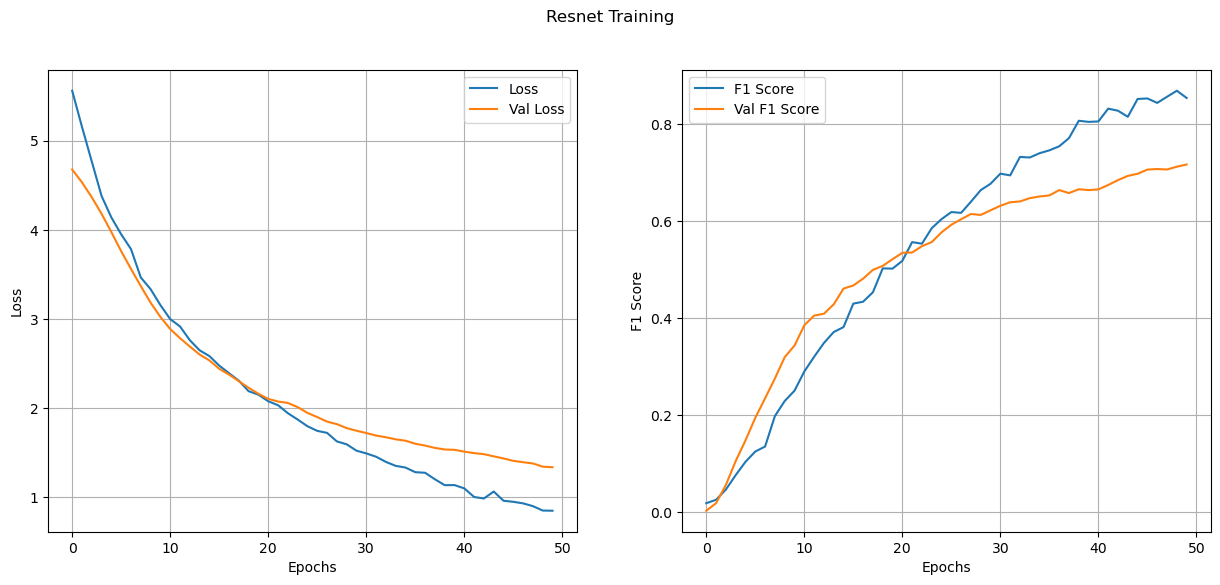

In [17]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.lineplot(resnet_history.history['loss'], label='Loss')
sns.lineplot(resnet_history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()

plt.subplot(1, 2, 2)
sns.lineplot(resnet_history.history['f1_score'], label='F1 Score')
sns.lineplot(resnet_history.history['val_f1_score'], label='Val F1 Score')
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.grid()

plt.suptitle("Resnet Training")

plt.show()

### 3.2 VGG16

In [8]:
vgg16_history = vgg16_model.fit(
    train_ds_vgg.prefetch(tf.data.AUTOTUNE),
    validation_data=val_ds_vgg.prefetch(tf.data.AUTOTUNE),
    epochs=10,
    callbacks=[early_stopping, lr_scheduler, checkpoint_callback("vgg16")],
    verbose=1,
)

Epoch 1/10


/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_364']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
2025-09-16 21:47:16.773011: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
I0000 00:00:1758059237.643123  196579 service.cc:148] XLA service 0x55cc875da610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758059237.643173  196579 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-09-16 21:47:17.739913: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758059238.199412  196579 cuda_dnn.cc:529] Loaded cuDN

 2/32 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.0000e+00 - f1_score: 0.0000e+00 - loss: 5.7599 

I0000 00:00:1758059247.592103  196579 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.0073 - f1_score: 0.0072 - loss: 5.6914       

2025-09-16 21:47:47.111123: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[28,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-09-16 21:47:47.527464: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[28,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[28,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationFor

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.0073 - f1_score: 0.0073 - loss: 5.6900
Epoch 1: val_f1_score improved from -inf to 0.00428, saving model to best_model_vgg16.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.0074 - f1_score: 0.0073 - loss: 5.6888 - val_accuracy: 0.0137 - val_f1_score: 0.0043 - val_loss: 5.5794 - learning_rate: 1.0000e-04
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.0229 - f1_score: 0.0192 - loss: 5.3066 
Epoch 2: val_f1_score improved from 0.00428 to 0.00682, saving model to best_model_vgg16.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 909ms/step - accuracy: 0.0229 - f1_score: 0.0193 - loss: 5.3058 - val_accuracy: 0.0118 - val_f1_score: 0.0068 - val_loss: 5.1068 - learning_rate: 1.0000e-04
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.0139 - f1_score: 0.0130 - loss: 5.1627         
Epoch 3: val_f1_score improved from 0.00682 to 0.02876, saving model to best_model_vgg16.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 

In [9]:
vgg16_history.history.keys()

dict_keys(['accuracy', 'f1_score', 'loss', 'val_accuracy', 'val_f1_score', 'val_loss', 'learning_rate'])

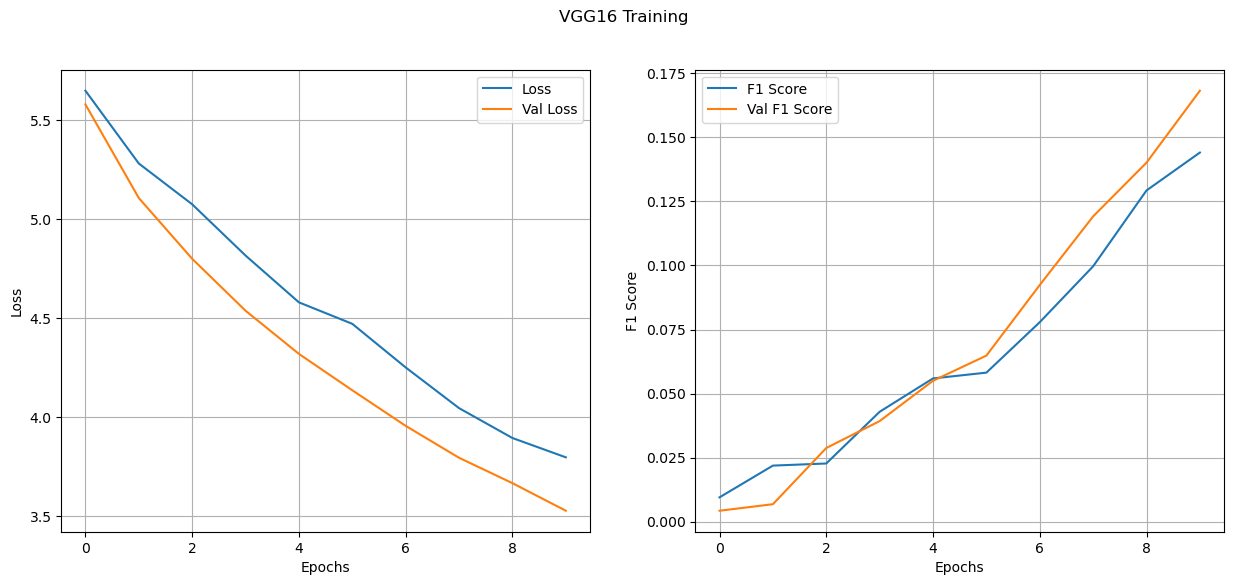

In [10]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.lineplot(vgg16_history.history['loss'], label='Loss')
sns.lineplot(vgg16_history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()

plt.subplot(1, 2, 2)
sns.lineplot(vgg16_history.history['f1_score'], label='F1 Score')
sns.lineplot(vgg16_history.history['val_f1_score'], label='Val F1 Score')
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.grid()

plt.suptitle("VGG16 Training")

plt.show()

### 3.3 MobileNetV2

In [11]:
mobilenet_history = mobilenetv2_model.fit(
    train_ds_mobilenet,
    validation_data=val_ds_mobilenet,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler, checkpoint_callback("mobile")],
    verbose=1,
)

Epoch 1/10


/opt/conda/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_411']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1758059685.683636  203325 service.cc:148] XLA service 0x7f94a40037f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758059685.683695  203325 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-09-16 21:54:45.829321: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1758059686.740918  203325 cuda_dnn.cc:529] Loaded cuDNN version 90300


 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0253 - f1_score: 0.0119 - loss: 5.6963 

I0000 00:00:1758059691.456496  203325 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.0122 - f1_score: 0.0082 - loss: 5.7044
Epoch 1: val_f1_score improved from -inf to 0.00641, saving model to best_model_vgg16.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 983ms/step - accuracy: 0.0121 - f1_score: 0.0082 - loss: 5.7027 - val_accuracy: 0.0118 - val_f1_score: 0.0064 - val_loss: 4.6310 - learning_rate: 1.0000e-04
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.0211 - f1_score: 0.0183 - loss: 5.1974 
Epoch 2: val_f1_score improved from 0.00641 to 0.01749, saving model to best_model_vgg16.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 25s 786ms/step - accuracy: 0.0212 - f1_score: 0.0185 - loss: 5.1976 - val_accuracy: 0.0255 - val_f1_score: 0.0175 - val_loss: 4.5449 - learning_rate: 1.0000e-04
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.0356 - f1_score: 0.0269 - loss: 4.8686 
Epoch 3: val_f1_score improved from 0.01749 to 0.03275, saving model to best_model_vgg16.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 801ms

In [12]:
mobilenet_history.history.keys()

dict_keys(['accuracy', 'f1_score', 'loss', 'val_accuracy', 'val_f1_score', 'val_loss', 'learning_rate'])

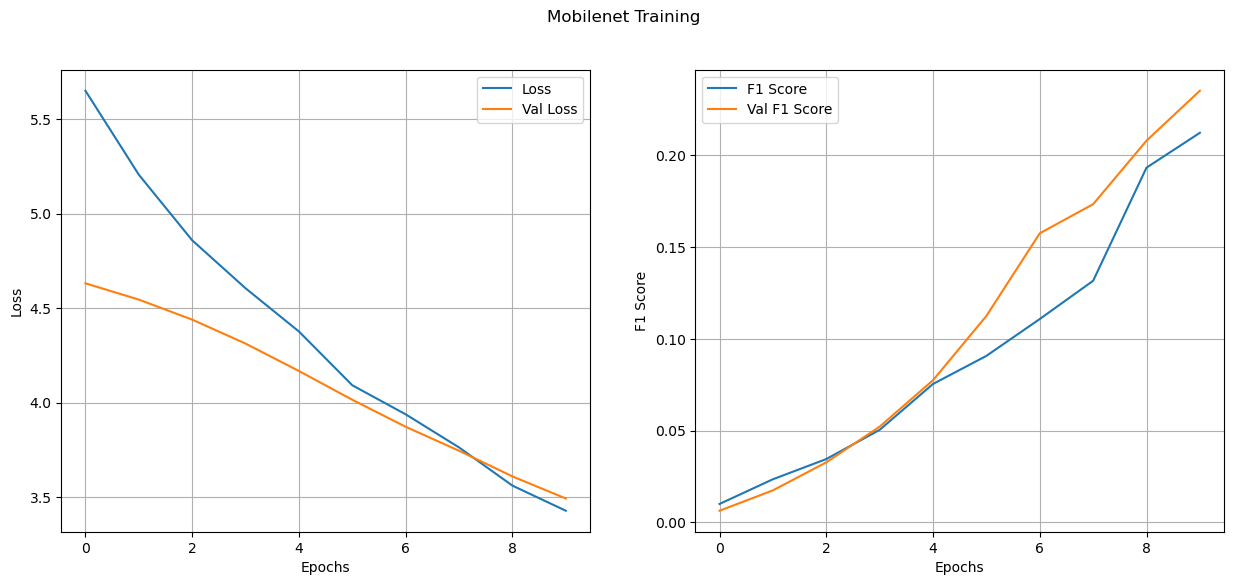

In [13]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.lineplot(mobilenet_history.history['loss'], label='Loss')
sns.lineplot(mobilenet_history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()

plt.subplot(1, 2, 2)
sns.lineplot(mobilenet_history.history['f1_score'], label='F1 Score')
sns.lineplot(mobilenet_history.history['val_f1_score'], label='Val F1 Score')
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.grid()

plt.suptitle("Mobilenet Training")

plt.show()

## 4. Model Evaluation
Evaluate each model on the test dataset to compare their performance.

### 4.1. Load best models

In [26]:
resnet_model_ = keras.saving.load_model('best_model_resnet.keras')
vgg16_model_ = keras.saving.load_model('best_model_resnet_.keras')
mobilenetv2_model_ = keras.saving.load_model('best_model_vgg16.keras')

### 4.2. Run evaluation on test data

In [27]:
resnet_eval = resnet_model_.evaluate(test_ds.map(lambda img, label: (resnet_processor(img), label)), return_dict=True)
vgg16_eval = vgg16_model_.evaluate(test_ds.map(lambda img, label: (vgg16_processor(img), label)), return_dict=True)
mobilenet_eval = mobilenetv2_model_.evaluate(test_ds.map(lambda img, label: (mobilenet_processor(img), label)), return_dict=True)

193/193 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - accuracy: 0.6829 - f1_score: 0.6422 - loss: 1.4954
193/193 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - accuracy: 0.2369 - f1_score: 0.2227 - loss: 3.6841
193/193 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.1975 - f1_score: 0.1897 - loss: 3.6370


In [28]:
resnet_eval, vgg16_eval, mobilenet_eval

({'accuracy': 0.6885672211647034,
  'f1_score': 0.6718118786811829,
  'loss': 1.4830584526062012},
 {'accuracy': 0.23646120727062225,
  'f1_score': 0.22742940485477448,
  'loss': 3.686742067337036},
 {'accuracy': 0.19710521399974823,
  'f1_score': 0.19463449716567993,
  'loss': 3.6516053676605225})

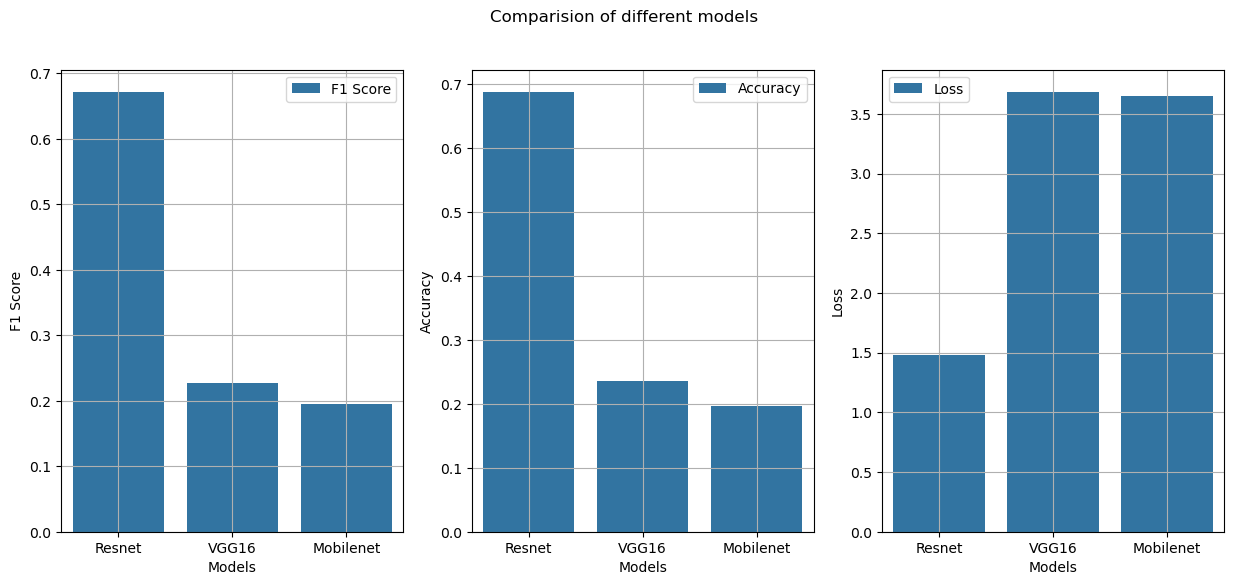

In [29]:
plt.figure(figsize=(15, 6))
plt.suptitle('Comparision of different models')

plt.subplot(1, 3, 1)
sns.barplot(x=['Resnet', 'VGG16', 'Mobilenet'], y=[resnet_eval['f1_score'], vgg16_eval['f1_score'], mobilenet_eval['f1_score']], label='F1 Score')
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
sns.barplot(x=['Resnet', 'VGG16', 'Mobilenet'], y=[resnet_eval['accuracy'], vgg16_eval['accuracy'], mobilenet_eval['accuracy']], label='Accuracy')
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
sns.barplot(x=['Resnet', 'VGG16', 'Mobilenet'], y=[resnet_eval['loss'], vgg16_eval['loss'], mobilenet_eval['loss']], label='Loss')
plt.xlabel("Models")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.show()

## Project Summary

*   **Data Loading and Preprocessing**: Loaded the Oxford Flowers 102 dataset and preprocessed images using model-specific functions (ResNet50, VGG16, MobileNetV2).
*   **Model Adaptation**: Loaded pre-trained ResNet50, VGG16, and MobileNetV2 models (without top layers), added new classification layers for 102 classes, and initially froze base model layers.
*   **Model Compilation**: Compiled each modified model with the 'adam' optimizer, 'categorical\_crossentropy' loss, with 'f1-score' & 'accuracy' metrics.
*   **Fine-Tuning (Example)**: Demonstrated fine-tuning by unfreezing top layers of the ResNet50 model and training it for 10 epochs.
*   **Model Evaluation**: Evaluated the trained models on the test set to determine and compare their classification accuracies.

## Conclusion

Successfully fine-tuned 3 models for Oxford Flowers 102 dataset.

- **ResNet50**: Acheived 68.7% Accuracy
- **VGG16**: 23.6% Accuracy due to lower epoch count
- **MobileNetV2**: 19.7% Accuracy due to lower epoch count and lesser parameters